# Optimisation: Ask-and-tell interface

If you want more control than the `Optimisation` interface offers, you can access optimisation methods directly via an "ask-and-tell" interface.

First, we set up a problem:

In [8]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.Boundaries([0, 200], [1, 1000])

# Choose an initial position
x0 = [0, 700]

Next, we create an XNES optimiser object and run a simple optimisation:

Now we can run a simple optimisation:

In [13]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
for i in range(500):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores for each point
    fxs = [score(x) for x in xs]
    # Pass the result back to XNES
    xnes.tell(fxs)

# Show the best solution
print(xnes.xbest())

[  1.50059693e-02   4.99312206e+02]


One advantage of this type of interface is that it gives us the freedom to evaluate the score function in any way we like. For example using parallelisation:

In [14]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Create parallel evaluator
e = pints.ParallelEvaluator(score)

# Run optimisation
for i in range(500):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores in parallel!
    fxs = e.evaluate(xs)
    # Pass the result back to XNES
    xnes.tell(fxs)

# Show the best solution
print(xnes.xbest())

[  1.50059693e-02   4.99312206e+02]


Note that, for our toy problem, the time it takes to set up parallelisation actually outweighs its benefits!

Another thing we can do is track exactly what happens over time:

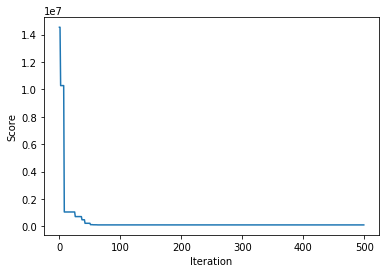

In [18]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
best = []
for i in range(500):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores
    fxs = [score(x) for x in xs]
    # Pass the result back to XNES
    xnes.tell(fxs)
    # Store the best score
    best.append(xnes.fbest())

# Show how the score converges
plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.plot(best)
plt.show()

For a simple 2d problem, we can also graph the trajectory of the optimiser through the parameter space

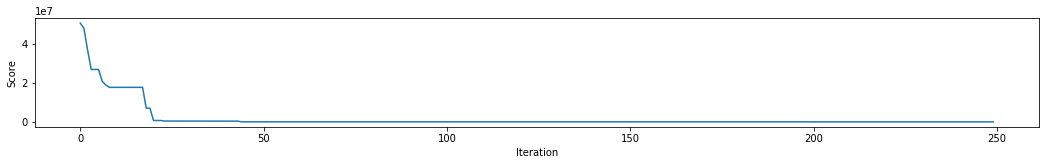

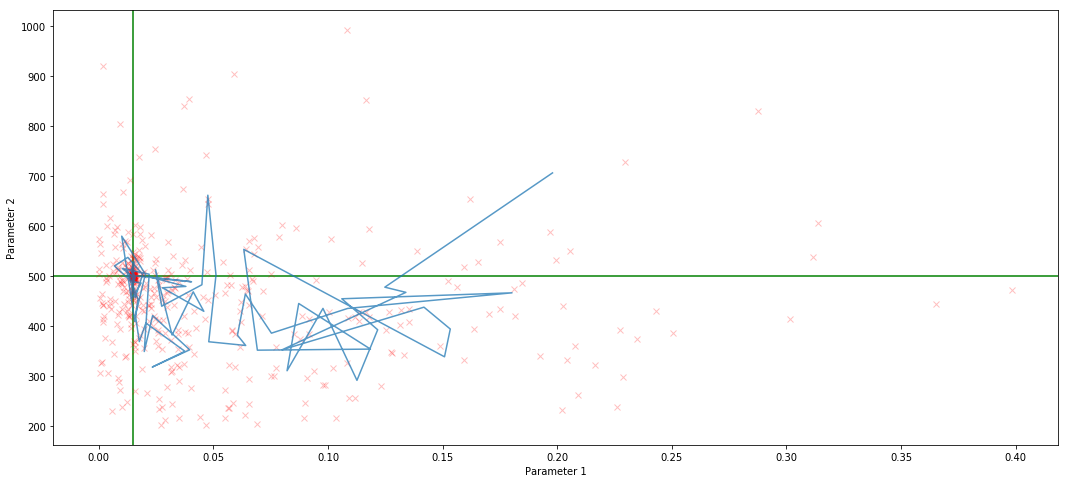

In [43]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
best = []
mean = []
allx = []
for i in range(250):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores
    fxs = [score(x) for x in xs]
    # Pass the result back to XNES
    xnes.tell(fxs)
    # Store the best score
    best.append(xnes.fbest())
    # Store the mean of the population of points
    mean.append(np.mean(xs, axis=0))
    # Store all requested points
    allx.extend(xs)
mean = np.array(mean)
allx = np.array(allx)

# Plot the optimiser convergence
plt.figure(figsize=(18, 2))
plt.xlabel('Iteration')
plt.ylabel('Score')
pl.plot(best)

# Plot the optimiser trajectory
plt.figure(figsize=(18, 8))
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.axhline(real_parameters[1], color='green')
plt.axvline(real_parameters[0], color='green')
plt.plot(allx[:, 0], allx[:, 1], 'x', color='red', alpha=0.25)
plt.plot(mean[:, 0], mean[:, 1], alpha=0.75)
plt.show()